In [1]:
from gensim import corpora, models

In [2]:
import pandas as pd
from urllib import request
from urllib.error import HTTPError
import matplotlib.pyplot as plt
import numpy as np
from janome.tokenizer import Tokenizer
# from gensim import corpora, models
import re
import unicodedata
from collections import Counter
import requests

import japanize_matplotlib

# Change fontype of pyplot
#import matplotlib.font_manager
#print([f.name for f in matplotlib.font_manager.fontManager.ttflist])
#plt.rcParams['font.family'] = 'MS Gothic'

In [3]:
# Load
df = pd.read_csv("./SuperD_Class5_keiki.csv")

# change to datetime format
df["date"] = pd.to_datetime(df["date"],format="%Y_%m_%d")

In [4]:
df

,region,symbol,industry,topic,text,date,type,label
0,北海道,◎,－,－,－,2010-02-08,now,5.0
1,北海道,○,商店街（代表者）,販売量の動き,・例年にないほど寒く、雪も多かったことから、防寒靴や手袋・マフラーなどの軽衣料などが良く売れ...,2010-02-08,now,4.0
2,北海道,○,百貨店（販売促進担当）,来客数の動き,・年末から来客数が微増で推移している。,2010-02-08,now,4.0
3,北海道,○,スーパー（店長）,販売量の動き,・３か月前と比較して販売量は減っているが、日曜が１日多かったこともあり、前年比は104.7％...,2010-02-08,now,4.0
4,北海道,○,旅行代理店（従業員）,来客数の動き,・１月半ばから来客数が増えてきている。ただ、低価格志向は相変わらずであり、売上が一気に好転す...,2010-02-08,now,4.0
...,...,...,...,...,...,...,...,...
462552,沖縄,○,職業安定所（職員）,NaN,・求人票へ記載される賃金が増加しているため、今後、更に全体の賃上げが進んでいくと期待している。,2024-03-08,future,4.0
462553,沖縄,□,人材派遣会社（総務担当）,NaN,・派遣からの直接雇用で企業の人員確保が増加して、派遣業はなかなか厳しい状況である。,2024-03-08,future,3.0
462554,沖縄,□,学校［大学］（就職支援担当）,NaN,・消費は増えているが、人材不足を理由に仕事を増やせないという話なども聞く。人材供給が追い付く...,2024-03-08,future,3.0
462555,沖縄,▲,－,NaN,－,2024-03-08,future,2.0


地域・産業を絞る Restrict to region industry pairs that has more than 1000 records 

In [5]:
cond = df["industry"] != "－"
df = df.loc[cond].copy()
df["region-industry"] = df["region"] + "-" + df["industry"]

df_reg_ind = pd.DataFrame(df[["region","industry","region-industry"]].value_counts())
df_reg_ind.reset_index(inplace=True)
df_reg_ind.columns = ["region","industry","region-industry","count"]
cond = (df_reg_ind["count"] > 999) 
df_reg_ind_use = df_reg_ind.loc[cond].copy()

use_region_industry = dict()
for text in df_reg_ind_use["region-industry"]:
    use_region_industry.update({text:1})
df["hantei"] = df["region-industry"].map(use_region_industry)
cond =df["hantei"] == 1

df = df.loc[cond].copy()

date2index = dict()
uni_dates = list(set(df["date"]))
uni_dates.sort()
for i in range(len(uni_dates)):
    date2index.update({uni_dates[i]:i})
    
df_reg_ind_use.sort_values(by=["industry","region"],ascending=[True,True],inplace=True)

In [6]:
docs,doc_info = [],[]
for i in range(len(df_reg_ind_use)):
    region_industry = df_reg_ind_use["region-industry"].iloc[i]
    v1 = region_industry.split("-")
    region = v1[0]
    industry = v1[1]
    # Restrict to a region industry pair
    cond = df["region-industry"] == region_industry 
    df_tmp = df.loc[cond].copy()
    uni_dates = list(set(df_tmp["date"]))
    uni_dates.sort()
    for j in range(len(uni_dates)):
        cond = df_tmp["date"] == uni_dates[j]
        df_tmp_2 = df_tmp.loc[cond].copy()
        all_text = ""
        for k in range(len(df_tmp_2)):
            text = df_tmp_2["text"].iloc[k]
            text = text.replace("\n","")
            text = text.replace(" ","")
            text = text.replace("・","")
            text = re.sub(r'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', '', text) #半角記号削除
            text = re.sub(r'\d+', '0', text) #数字を全て0に置換
            text = unicodedata.normalize('NFKC', text) #半角/全角などを統一
            text = text.lower() #大文字/小文字を統一
            all_text += text
        docs.append(all_text)
        doc_info.append([ region, industry, uni_dates[j], i, date2index[uni_dates[j]]])

In [7]:
docs[:5]

['前月に引き続き、客単価の低下がみられることに加えて、今月に入り、買上点数の減少もみられるようになってきた。年末から客単価が前年を0%下回っている。0月に入り、たばこやビールの販売量も減少している。来客数は前年並みを維持しているが、客単価は前年を下回っている。正月も旅行に行かないで家で過ごす人が多かったように、全体的に節約志向がみられることから、今後も変わらないまま推移する。正月明け以降、0日の給料日前後まで、客単価の低下や買上点数の減少という動きがみられた。所得減少の影響か、消費減退の傾向が強まっており、今後についてはやや悪くなる。周辺の製造業についても、一時的には回復している状況にあるが、今後の悪化が見込まれる。たばこやビールなど日々消費する商品の売上減少が続き、節約志向がより強まっている。販売量は前年より増加しているが、高単価商品の販売減少に歯止めがかかっていない。',
 '客単価の低下が進んでいるほか、買上点数の伸びも鈍化している。年明けからこの傾向が強まっている。低単価商品の販売量が増加しているが、客単価低下の影響が大きく、売上は相変わらず低迷している。客が0回の買物に使う金額の前年比は、この半年間変わらないまま推移している。売れる商品も変わっていないため、0月ごろまではこのままの状態で推移する。たばこやアルコールの販売量の減少が続いている。雑誌の販売量も低迷しており、余計な商品を節約する傾向が強まっている。大手自動車メーカーの今後の生産体制に不安が感じられることから、製造業への影響が懸念される。また、現在行われている公共工事も年度末に近付き、規模が縮小していくことから、今後についてはやや悪くなる。',
 '年度末に向けて増加していた各種工事が次々と終息に向かっているため、店舗での売上も鈍化している。単価の低い商品の売上が伸びている。一方、客0人当たりの買上点数は伸びているが、購入額は前年を下回っており、こうした状態が半年近く続いている。客単価が低いことから景気が悪いとみられるが、来客数が伸びていることから、景気は当面変わらない。最近の売上の伸びを支えていた工事需要が、0月以降減少することから、今後についてはやや悪くなる。また、前年比という観点では、前年の定額給付金の反動も生じる。',
 '消費の冷え込みは継続している。天候も悪かったことから、観光客や農

In [8]:
#Save for future use
df.to_csv("./region_industry_record.csv",index=False)

Topic Model

Preprocess

In [9]:
# Step 3: Tokenize Japanese text
tokenizer = Tokenizer()

def apply_tokenizer(document): #形態素解析を行い、名詞と動詞のみ抽出
    return [token.surface for token in tokenizer.tokenize(document) 
            if token.part_of_speech.split(',')[0] in ['名詞', '動詞']]

texts = [apply_tokenizer(doc) for doc in docs]

In [10]:
#ストップワード除去
##高頻度語と超低頻度語の除去
def get_frequency_stopwords(texts, n=100, min_freq=1):
    fdist = Counter()
    for text in texts:
        for word in text:
            fdist[word] += 1
    common_words = {word for word, freq in fdist.most_common(n)}
    rare_words = {word for word, freq in fdist.items() if freq <= min_freq}
    frequency_stopwords = common_words.union(rare_words)
    print('frequency based : {}/{}'.format(len(frequency_stopwords), len(fdist)))
    return frequency_stopwords

##ストップワード辞書に基づく除去
def get_dictionary_stopwords(url="http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"):
    ###slothlibプロジェクトで作成された日本語ストップワード辞書からdictionary_stopwordsを作成
    r = requests.get(url)
    tmp = r.text.split('\r\n')
    dictionary_stopwords = []
    for i in range(len(tmp)):
        if len(tmp[i]) < 1:
            continue
        dictionary_stopwords.append(tmp[i])
    ###独自に解釈性の低い言葉を追加
    dictionary_stopwords += [chr(i) for i in range(ord("ぁ"), ord("ゖ")+1)] #1文字のひらがなのリストを追加
    dictionary_stopwords += ["いる"] #補助動詞のリストを追加
    print('dictionary based : {}'.format(len(dictionary_stopwords)))
    return set(dictionary_stopwords)

##2種類のストップワードリストを結合
def get_stopwords(texts):
    frequency_stopwords = get_frequency_stopwords(texts)
    dictionary_stopwords = get_dictionary_stopwords()
    stopwords = frequency_stopwords.union(dictionary_stopwords)
    return stopwords

def remove_stopwords(words, stopwords):
    words = [word for word in words if word not in stopwords]
    return words

###適用###
def preprocess(texts):
    stopwords = get_stopwords(texts)
    preprocessed_texts = [remove_stopwords(text,stopwords) for text in texts]
    return preprocessed_texts

In [11]:
texts = preprocess(texts)

frequency based : 3741/12367
dictionary based : 397


In [12]:
pd.DataFrame(texts)

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,前月,引き続き,低下,加え,入り,買上,点数,年末,下回っ,入り,...,None,None,None,None,None,None,None,None,None,None
1,低下,進ん,買上,点数,鈍化,年明け,強まっ,低下,低迷,買物,...,None,None,None,None,None,None,None,None,None,None
2,年度,末,向け,各種,工事,終息,向かっ,店舗,鈍化,当たり,...,None,None,None,None,None,None,None,None,None,None
3,冷え込み,継続,農家,定額,給付,給付,反動,鈍化,定額,給付,...,None,None,None,None,None,None,None,None,None,None
4,気温,低下,農家,店舗,生じ,不順,農家,低温,比較,飲料,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,物価,燃料,高騰,購入,選ん,経費,削減,努め,変わっ,物価,...,None,None,None,None,None,None,None,None,None,None
8108,停滞,気味,物価,賃金,アップ,追い付い,おら,購買,意欲,低迷,...,None,None,None,None,None,None,None,None,None,None
8109,前月,同様,景況,必要,購入,症,分類,症,移行,業種,...,None,None,None,None,None,None,None,None,None,None
8110,個人,設備,投資,四半期,連続,個人,物価,節約,志向,高まり,...,None,None,None,None,None,None,None,None,None,None


Run

In [13]:
# Step 4: Create dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Step 5: Build LDA model
# Parameters
num_topics = 30  # Changed from 20 to 30
passes = 30  # Increased from 20 to 30 for more thorough learning
alpha = 0.1 #'auto'  # Let the model learn the document-topic density
eta = 0.1 #'auto'  # Let the model learn the topic-word density
update_every = 1  # Update parameters after every pass over the corpus
chunksize = 2000  # Use 2000 documents in each training chunk for faster training

# Create the LdaModel with the new parameters
lda_model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                     passes=passes, alpha=alpha, eta=eta, update_every=update_every, chunksize=chunksize)

# Step 6: Print the topics found by the LDA model
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(21, '0.080*"月間" + 0.037*"キャッシュ" + 0.033*"レス" + 0.033*"平成"')
(16, '0.067*"派遣" + 0.030*"会社" + 0.021*"契約" + 0.020*"年度"')
(1, '0.071*"加入" + 0.059*"サービス" + 0.046*"投資" + 0.039*"設備"')
(10, '0.029*"選挙" + 0.021*"%、" + 0.020*"海外" + 0.020*"地方"')
(12, '0.024*"意欲" + 0.016*"要求" + 0.015*"コスト" + 0.014*"メニュー"')
(5, '0.073*"緊急" + 0.072*"宣言" + 0.072*"事態" + 0.041*"解除"')
(6, '0.046*"物価" + 0.045*"高騰" + 0.036*"値上げ" + 0.016*"投資"')
(26, '0.078*"東日本" + 0.078*"大震災" + 0.030*"復興" + 0.018*"震災"')
(4, '0.041*"たばこ" + 0.025*"韓国" + 0.021*"飲料" + 0.020*"改善"')
(11, '0.195*"整備" + 0.026*"結び付く" + 0.021*"意思" + 0.015*"自家用車"')
(27, '0.022*"-" + 0.022*"申込" + 0.022*"貿易" + 0.020*"問題"')
(24, '0.011*"商店" + 0.011*"予約" + 0.010*"夜" + 0.010*"飲食"')
(20, '0.033*"衣料" + 0.019*"購買" + 0.017*"好調" + 0.017*"関連"')
(2, '0.039*"車" + 0.028*"来場" + 0.024*"自動車" + 0.022*"台数"')
(28, '0.066*"雇用" + 0.041*"純増" + 0.037*"貨物" + 0.037*"調整"')
(29, '0.053*"採用" + 0.041*"件数" + 0.020*"業界" + 0.015*"時期"')
(23, '0.064*"受注" + 0.035*"住宅" + 0.015*"件数" + 0.014*"目標"')
(15, 

In [14]:
if num_topics== 10:
    #Red: #FF6347,Green: #32CD32,Blue: #4169E1,Yellow: #FFD700,Orange: #FFA500,Purple: #800080,
    #Cyan: #00FFFF,Magenta: #EE82EE,Chocolate: #D2691E,Teal: #008080 
    color_list = [
        "#FF6347","#32CD32","#4169E1","#FFD700","#FFA500","#800080",
        "#00FFFF","#EE82EE","#D2691E", "#008080" 
    ]
        
elif num_topics == 20:
    ## 20 Colors
    #Red: #FF0000,Green: #008000,Blue: #0000FF,Yellow: #FFFF00,Orange: #FFA500,Purple: #800080
    #Cyan: #00FFFF,Magenta: #FF00FF,Lime Green: #32CD32,Teal: #008080,Olive: #808000,Maroon: #800000
    #Navy: #000080,Coral: #FF7F50,Turquoise: #40E0D0,Medium Slate Blue: #7B68EE,Dark Orange: #FF8C00
    #Light Pink: #FFB6C1,Beige: #F5F5DC,Light Gray: #D3D3D3

    # List of 20 distinct colors
    color_list = [
        "#FF0000", "#008000", "#0000FF", "#FFFF00", "#FFA500",
        "#800080", "#00FFFF", "#FF00FF", "#32CD32", "#008080",
        "#808000", "#800000", "#000080", "#FF7F50", "#40E0D0",
        "#7B68EE", "#FF8C00", "#FFB6C1", "#F5F5DC", "#D3D3D3"
    ]

elif num_topics == 30:
    
    #Red: #FF0000,Green: #008000,Blue: #0000FF,Yellow: #FFFF00,Orange: #FFA500,Purple: #800080,
    #Cyan: #00FFFF, Magenta: #FF00FF, Lime Green: #32CD32, Teal: #008080, Olive: #808000,Maroon: #800000,
    #Navy: #000080,Coral: #FF7F50,Turquoise: #40E0D0,Medium Slate Blue: #7B68EE,Dark Orange: #FF8C00
    #Light Pink: #FFB6C1,Beige: #F5F5DC,Light Gray: #D3D3D3,Chocolate: #D2691E,Tomato: #FF6347
    #Forest Green: #228B22,Violet: #EE82EE,Sienna: #A0522D,Gold: #FFD700,Deep Sky Blue: #00BFFF
    #Sandy Brown: #F4A460,Royal Blue: #4169E1,Mint Cream: #F5FFFA

    color_list = [
        "#FF0000", "#008000", "#0000FF", "#FFFF00", "#FFA500",
        "#800080", "#00FFFF", "#FF00FF", "#32CD32", "#008080",
        "#808000", "#800000", "#000080", "#FF7F50", "#40E0D0",
        "#7B68EE", "#FF8C00", "#FFB6C1", "#F5F5DC", "#D3D3D3",
        "#D2691E", "#FF6347", "#228B22", "#EE82EE", "#A0522D",
        "#FFD700", "#00BFFF", "#F4A460", "#4169E1", "#F5FFFA"
    ]
    
else:
     
    #Red: #FF0000,Green: #008000,Blue: #0000FF,Yellow: #FFFF00,Orange: #FFA500,Purple: #800080
    #Cyan: #00FFFF,Magenta: #FF00FF,Lime Green: #32CD32,Teal: #008080,Olive: #808000,Maroon: #800000
    #Navy: #000080,Coral: #FF7F50,Turquoise: #40E0D0,Medium Slate Blue: #7B68EE,Dark Orange: #FF8C00
    #Light Pink: #FFB6C1,Beige: #F5F5DC,Light Gray: #D3D3D3,Chocolate: #D2691E,Tomato: #FF6347
    #Forest Green: #228B22,Violet: #EE82EE,Sienna: #A0522D,Gold: #FFD700,Deep Sky Blue: #00BFFF
    #Sandy Brown: #F4A460,Royal Blue: #4169E1,Mint Cream: #F5FFFA,Deep Pink: #FF1493,Aqua: #00FFFF
    #Dark Violet: #9400D3,Peach Puff: #FFDAB9,Wheat: #F5DEB3,Cadet Blue: #5F9EA0,Periwinkle: #CCCCFF
    #Dark Goldenrod: #B8860B,Pale Green: #98FB98,Orchid: #DA70D6,Light Salmon: #FFA07A,Midnight Blue: #191970
    #Plum: #DDA0DD,Indian Red: #CD5C5C,Khaki: #F0E68C,Hot Pink: #FF69B4,Dark Sea Green: #8FBC8F,Cornflower Blue: #6495ED
    #Lemon Chiffon: #FFFACD,Thistle: #D8BFD8

    color_list = [
        "#FF0000", "#008000", "#0000FF", "#FFFF00", "#FFA500",
        "#800080", "#00FFFF", "#FF00FF", "#32CD32", "#008080",
        "#808000", "#800000", "#000080", "#FF7F50", "#40E0D0",
        "#7B68EE", "#FF8C00", "#FFB6C1", "#F5F5DC", "#D3D3D3",
        "#D2691E", "#FF6347", "#228B22", "#EE82EE", "#A0522D",
        "#FFD700", "#00BFFF", "#F4A460", "#4169E1", "#F5FFFA",
        "#FF1493", "#00FFFF", "#9400D3", "#FFDAB9", "#F5DEB3",
        "#5F9EA0", "#CCCCFF", "#B8860B", "#98FB98", "#DA70D6",
        "#FFA07A", "#191970", "#DDA0DD", "#CD5C5C", "#F0E68C",
        "#FF69B4", "#8FBC8F", "#6495ED", "#FFFACD", "#D8BFD8"
    ]

def hex_to_rgb(hex_color):
    # Convert hex to RGB
    return tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5))

Create Color Matrix

In [15]:
color_matrix = np.empty((len(use_region_industry),len(uni_dates)), dtype=object)
for i, row in enumerate(lda_model[corpus]):
    max_topic = -1
    max_value = -1
    
    for topic_id, prop in row:
        if prop > max_value:
            max_topic = topic_id
            max_value = prop
    row = doc_info[i][3]
    col = doc_info[i][4]
    
    color_matrix[row,col] = color_list[max_topic]

In [16]:
# Convert the color_matrix from hex codes to normalized RGB values
rgb_matrix = np.array([[hex_to_rgb(color) for color in row] for row in color_matrix])/255

Plot result

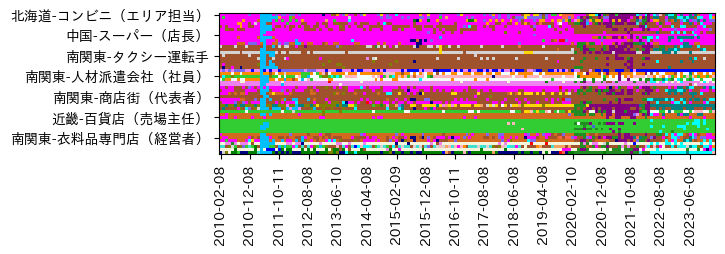

In [17]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create a color matrix visualization
plt.imshow(rgb_matrix, interpolation='nearest', aspect='equal')

# Set tick positions
x_ticks = [i for i in range(len(uni_dates)) if i % 10 == 0]
use_dates = []
for i in x_ticks:
    use_dates.append(uni_dates[i].date())
ax.set_xticks(x_ticks)
ax.set_xticklabels(use_dates)
# Set the ticks and labels on
plt.xticks(rotation=90)  # Optional: Rotate labels if they overlap or for better readability

y_ticks = [i for i in range(len(df_reg_ind_use)) if i % 7 == 0]
use_region_industry = []
for i in y_ticks:
    use_region_industry.append(df_reg_ind_use["region-industry"].iloc[i])
ax.set_yticks(y_ticks)
ax.set_yticklabels(use_region_industry)

plt.show()